### Growth factor-mediated coupling between lineage size and cell fate choice underlies robustness of mammalian development

#### N. Saiz, L. Mora-Bitria, S. Rahman, H. George, J.P. Herder, J. García-Ojalvo and A.-K. Hadjantonakis

#### **Figure 4**

This code reproduces the effect of ablating cells on our model of EPI-PrE cell fate choice in the early embryo. Running this code requires the C compiler `cc` and the utility `make`. Both are available by default in Linux, or by installing the `Xcode` development environment in Mac OS X.

First, we load all necessary packages:

In [16]:
import numpy as np
from IPython.display import clear_output
import subprocess
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20

Now we compile the C code:

In [17]:
try:
    out = subprocess.check_output('make --file=Makefile_v1 clean', shell=True)
    outlist = out.decode().split('\n')
    for outline in outlist:
        print(outline)
except:
    pass

p = subprocess.Popen(["make","--file=Makefile_v1"],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
while True:
    ln = p.stdout.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)
while True:
    ln = p.stderr.readline().decode().rstrip()
    if ln == '':
            break
    print(ln)

rm *.o

cc -O3 -c dran.c -o dran.o
cc -O3 -c embryo_v1.c
cc embryo_v1.o dran.o -o embryo_v1 -lm


We now define a function `run` that generates the parameter value file and runs the C code. Some of the parameters are introduced as arguments to the function, the rest are hard-coded within it.

In [18]:
def run(nruns=10, alpha=10, Kf=0.9, nth=0.8, gth=0.2, n0=2, n0sd=0,
        N2start=20, N2startsd=2, N2ablate=100, fate2ablate=3, p2ablate=0.3,
        mt=0.01, rntd=0.01, nth2=0.95, gth2=0.05, Nmax=50, rngseed=1000):
    fname = 'output/dset_v1_%i'%rngseed
    pfile = open(fname+'.par', 'w')
    pfile.write('%s    nruns\n'%nruns)
    pfile.write('1e-6    initial_mass\n')
    pfile.write('5.0    initial_radius\n')
    pfile.write('1e-6    effective_friction\n')
    pfile.write('1e-4    adhesion_strength\n')
    pfile.write('1.5    adhesion_strength_reduction_for_different_cell_types\n')
    pfile.write('2.0    adhesion_range\n')
    pfile.write('%s    alpha\n'%alpha)
    pfile.write('%s    Kf\n'%Kf)
    pfile.write('2    nh\n')
    pfile.write('2    mh\n')
    pfile.write('1.2    fd_FGF_range_factor\n')
    pfile.write('%s    nth_minimum_fraction_of_Nanog_max_for_EPI_allocation\n'%nth)
    pfile.write('%s    gth_maximum_fraction_of_Nanog_max_for_PrE_allocation\n'%gth)
    pfile.write('%s    nth2_maximum_Nanog_max_for_circuit_function\n'%nth2)
    pfile.write('%s    gth2_minimum_Nanog_max_for_circuit_function\n'%gth2)
    pfile.write('%s    maximum_cell_number\n'%Nmax)
    pfile.write('10         division_time\n')
    pfile.write('0.5         dispersion_in_division_time\n')
    pfile.write('300.0         final_time\n')
    pfile.write('%s          measuring_time\n'%mt)
    pfile.write('0.001        integration_time_step\n')
    pfile.write('%i          random_number_generator_seed\n'%rngseed)   #rng seed
    pfile.write('%s          initial_DC_Nanog\n'%n0)
    pfile.write('%s          initial_noise_Nanog\n'%n0sd)
    pfile.write('%s          division_noise\n'%rntd)  #0.01
    pfile.write('%s          mean_cell_number_to_start_biochemistry\n'%N2start)
    pfile.write('%s          std_cell_number_to_start_biochemistry\n'%N2startsd)
    pfile.write('%s          cell_number_to_start_ablation\n'%N2ablate)
    pfile.write('%s          cell_type_to_ablate\n'%fate2ablate)
    pfile.write('%s          cell_fraction_to_ablate\n'%p2ablate)
    pfile.close()

    p = subprocess.Popen(['time','embryo_v1',fname],
                         stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    while True:
        ln = p.stdout.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)
    while True:
        ln = p.stderr.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)

Next we define two plotting functions:

In [19]:
def plot_fractions_vs_time(N2ablate=100,nruns=1,tmin=40*90/56,tmax=60*90/56,
                           tshift=0,nmin=-1,nmax=50,figname='',figtitle=''):
    tscale = 90/56
    fname = 'output/dset_v1_%i'%rngseed
    tvec = []
    fdpvec = []
    fepivec = []
    fprevec = []
    fdp2vec = []
    fepi2vec = []
    fpre2vec = []
    Nvec = []
    if nruns>1:
        sddpvec = []
        sdepivec = []
        sdprevec = []
        sdNvec = []
    data = open(fname+'.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
        tvec.append(snap[0]+tshift)
        fdpvec.append(snap[1]*100)
        fepivec.append(snap[2]*100)
        fprevec.append(snap[3]*100)
        fdp2vec.append(snap[4]*100)
        fepi2vec.append(snap[5]*100)
        fpre2vec.append(snap[6]*100)
        Nvec.append(snap[7])
        if nruns>1:
            if snap[4]-snap[1]**2>0:
                sddpvec.append(np.sqrt(snap[4]-snap[1]**2)*100)
            else:
                sddpvec.append(0)
            if snap[5]-snap[2]**2>0:
                sdepivec.append(np.sqrt(snap[5]-snap[2]**2)*100)
            else:
                sdepivec.append(0)
            if snap[6]-snap[3]**2>0:
                sdprevec.append(np.sqrt(snap[6]-snap[3]**2)*100)
            else:
                sdprevec.append(0)
            if snap[8]-snap[7]**2>0:
                sdNvec.append(np.sqrt(snap[8]-snap[7]**2))
            else:
                sdNvec.append(0)
    plt.figure()
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    if nruns>1:
        ax1.errorbar(np.asarray(tvec)*tscale,fdpvec,yerr=sddpvec,capsize=4,fmt='om-',label='DP')
        ax1.errorbar(np.asarray(tvec)*tscale,fepivec,yerr=sdepivec,capsize=4,fmt='or-',label='EPI')
        ax1.errorbar(np.asarray(tvec)*tscale,fprevec,yerr=sdprevec,capsize=4,fmt='ob-',label='PrE')
        ax2.errorbar(np.asarray(tvec)*tscale,Nvec,yerr=sdNvec,fmt='o-',color='grey',label='all')
    else:
        ax1.plot(np.asarray(tvec)*tscale,fdpvec,'m-',label='DP')
        ax1.plot(np.asarray(tvec)*tscale,fepivec,'r-',label='EPI')
        ax1.plot(np.asarray(tvec)*tscale,fprevec,'b-',label='PrE')
        ax2.plot(np.asarray(tvec)*tscale,Nvec,'grey',label='all')
    if N2ablate<100:
        ax2.axhline(N2ablate,color='k',linestyle=':')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize=15)
    ax1.axhline(50,color='k',linestyle='--')
    ax1.set_xlabel('time (hpf)')
    ax1.set_ylabel('% of ICM')
    ax1.set_xlim([tmin,tmax])
    ax1.set_ylim([-2,102])
    ax2.set_ylabel('cell number', rotation=270, labelpad=20, color='grey')
    ax2.tick_params(axis='y', colors='grey')
    ax2.set_ylim([nmin,nmax])
    plt.title(figtitle)
    plt.tight_layout()
    plt.savefig('figures/fig4_%s.pdf'%figname)
    plt.show()

Using the functions defined above, now we study the response of the developing embryo to cell ablation, varying the cell type being ablated and the number of cells affected.

**Random ablation**

We first ablate 30% of all cells from the embryo at the 27 ICM-cell stage, with their fates chosen randomly.

Ablating cell 0 with fate 2
Ablating cell 1 with fate 2
Ablating cell 5 with fate 2
Ablating cell 7 with fate 2
Ablating cell 11 with fate 0
Ablating cell 12 with fate 2
Ablating cell 13 with fate 1
Ablating cell 18 with fate 1
Ablating cell 22 with fate 1
        0.84 real         0.59 user         0.01 sys


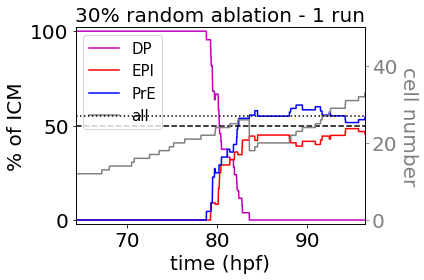

In [20]:
nruns = 1
N2ablate = 27
fate2ablate = 3
p2ablate = 0.3
rngseed = 11*N2ablate+2

run(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    rngseed=rngseed)

plot_fractions_vs_time(N2ablate=N2ablate, nruns=nruns,
                       figname='30pct_random_ablation_1_run',
                       figtitle='30% random ablation - 1 run')

       44.00 real        43.09 user         0.14 sys


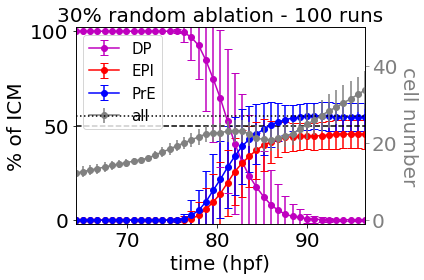

In [21]:
nruns = 100
N2ablate = 27
fate2ablate = 3
p2ablate = 0.3
rngseed = 11*N2ablate+10
mt = 0.5

run(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    rngseed=rngseed, mt=mt)

plot_fractions_vs_time(N2ablate=N2ablate, nruns=nruns,
                       figname='30pct_random_ablation_100_runs',
                       figtitle='30% random ablation - 100 runs')

Next we ablate *all* PrE cells from the embryo at the 27 ICM-cell stage.

Ablating cell 1 with fate 2
Ablating cell 10 with fate 2
Ablating cell 11 with fate 2
Ablating cell 12 with fate 2
Ablating cell 13 with fate 2
Ablating cell 15 with fate 2
Ablating cell 19 with fate 2
Ablating cell 23 with fate 2
Ablating cell 25 with fate 2
Ablating cell 26 with fate 2
        0.55 real         0.53 user         0.01 sys


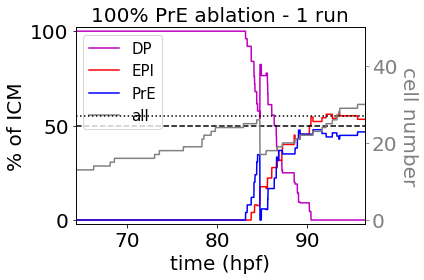

In [22]:
nruns = 1
N2ablate = 27
fate2ablate = 2
p2ablate = 1.0
rngseed = 12*N2ablate+3

run(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    rngseed=rngseed)

plot_fractions_vs_time(N2ablate=N2ablate, nruns=nruns,
                       figname='100pct_PrE_ablation_1_run',
                       figtitle='100% PrE ablation - 1 run')

       41.06 real        40.86 user         0.05 sys


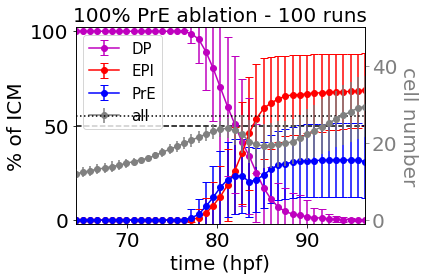

In [23]:
nruns = 100
N2ablate = 27
fate2ablate = 2
p2ablate = 1.0
rngseed = 11*N2ablate+10
mt = 0.5

run(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    rngseed=rngseed, mt=mt)

plot_fractions_vs_time(N2ablate=N2ablate, nruns=nruns,
                       figname='100pct_PrE_ablation_100_runs',
                       figtitle='100% PrE ablation - 100 runs')

Next we ablate *all* EPI cells from the embryo at the 27 ICM-cell stage.

Ablating cell 1 with fate 1
Ablating cell 6 with fate 1
Ablating cell 10 with fate 1
Ablating cell 13 with fate 1
Ablating cell 15 with fate 1
Ablating cell 20 with fate 1
Ablating cell 21 with fate 1
Ablating cell 24 with fate 1
Ablating cell 25 with fate 1
        0.54 real         0.52 user         0.01 sys


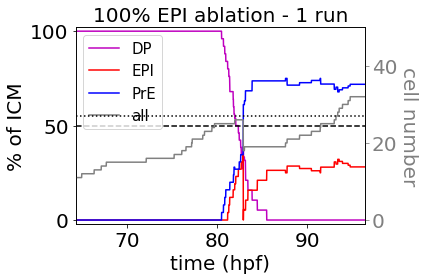

In [24]:
nruns = 1
N2ablate = 27
fate2ablate = 1
p2ablate = 1.0
rngseed = 12*N2ablate+2

run(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    rngseed=rngseed)

plot_fractions_vs_time(N2ablate=N2ablate, nruns=nruns,
                       figname='100pct_EPI_ablation_1_run',
                       figtitle='100% EPI ablation - 1 run')


       38.98 real        38.83 user         0.04 sys


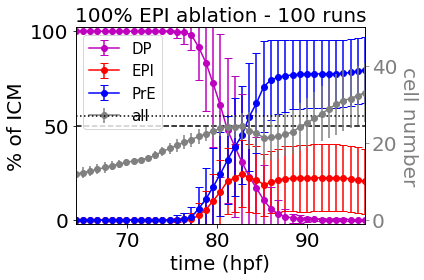

In [25]:
nruns = 100
N2ablate = 27
fate2ablate = 1
p2ablate = 1.0
rngseed = 11*N2ablate+10
mt = 0.5

run(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate,
    rngseed=rngseed, mt=mt)

plot_fractions_vs_time(N2ablate=N2ablate, nruns=nruns,
                       figname='100pct_EPI_ablation_100_runs',
                       figtitle='100% EPI ablation - 100 runs')


#### **Scanning the ablation times**

Now we create a new function that runs a scan over a range of ablation times.

In [26]:
def run_scan(nruns=10, alpha=10, Kf=0.9, nth=0.8, gth=0.2, n0=3, n0sd=0,
             N2start=20, N2startsd=2, N2ablate=27, fate2ablate=3, p2ablate=0.0,
             mt=0.5, rntd=0.01, nth2=0.95, gth2=0.05, rngseed=1234):

    fname = 'output/dset_v1_%s'%rngseed
    pfile = open(fname+'.par', 'w')
    pfile.write('%s    nruns\n'%nruns)
    pfile.write('1e-6    initial_mass\n')
    pfile.write('5.0    initial_radius\n')
    pfile.write('1e-6    effective_friction\n')
    pfile.write('1e-4    adhesion_strength\n')
    pfile.write('1.5    adhesion_strength_reduction_for_different_cell_types\n')
    pfile.write('2.0    adhesion_range\n')
    pfile.write('%s    alpha\n'%alpha)
    pfile.write('%s    Kf\n'%Kf)
    pfile.write('2    nh\n')
    pfile.write('2    mh\n')
    pfile.write('1.2    fd_FGF_range_factor\n')
    pfile.write('%s    nth_minimum_fraction_of_Nanog_max_for_EPI_allocation\n'%nth)
    pfile.write('%s    gth_maximum_fraction_of_Nanog_max_for_PrE_allocation\n'%gth)
    pfile.write('%s    nth2_maximum_Nanog_max_for_circuit_function\n'%nth2)
    pfile.write('%s    gth2_minimum_Nanog_max_for_circuit_function\n'%gth2)
    pfile.write('50    maximum_cell_number\n')
    pfile.write('10         division_time\n')
    pfile.write('0.5         dispersion_in_division_time\n')
    pfile.write('100.0         final_time\n')
    pfile.write('%s          measuring_time\n'%mt)
    pfile.write('0.001        integration_time_step\n')
    pfile.write('%i          random_number_generator_seed\n'%rngseed)   #rng seed
    pfile.write('%s          initial_DC_Nanog\n'%n0)
    pfile.write('%s          initial_noise_Nanog\n'%n0sd)
    pfile.write('%s          division_noise\n'%rntd)  #0.01
    pfile.write('%s          mean_cell_number_to_start_biochemistry\n'%N2start)
    pfile.write('%s          std_cell_number_to_start_biochemistry\n'%N2startsd)
    pfile.write('%s          cell_number_to_start_ablation\n'%N2ablate)
    pfile.write('%s          cell_type_to_ablate\n'%fate2ablate)
    pfile.write('%s          cell_fraction_to_ablate\n'%p2ablate)
    pfile.close()
    
    p = subprocess.Popen(['embryo_v1',fname],stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    while True:
        ln = p.stdout.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)
    while True:
        ln = p.stderr.readline().decode().rstrip()
        if ln == '':
                break
        print(ln)

    data = open(fname+'_binned.dat', 'r')
    for it,line in enumerate(data):
        snap_raw = line.rstrip(' \n').split(' ')
        snap = np.array(list(map(float, snap_raw)))
    fdp = snap[1]*100
    fepi = snap[2]*100
    fpre = snap[3]*100
    N = snap[0]
    sddp = (snap[4]-snap[1]**2)*100
    sdepi = (snap[5]-snap[2]**2)*100
    sdpre = (snap[6]-snap[3]**2)*100
    
    return [N,fdp,fepi,fpre,sddp,sdepi,sdpre]

We first use the function above to scan the **random ablation** case, for two fractions of cells being ablated: 10% and 30%.

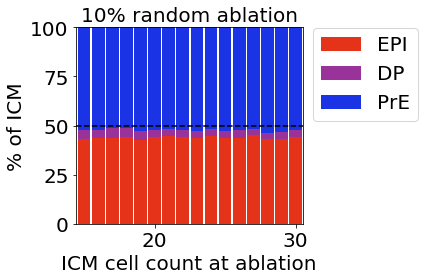

In [27]:
N2abvec = np.arange(15,31,1)
Nvec = np.zeros(len(N2abvec))
dpvec = np.zeros(len(N2abvec))
epivec = np.zeros(len(N2abvec))
prevec = np.zeros(len(N2abvec))
sddpvec = np.zeros(len(N2abvec))
sdepivec = np.zeros(len(N2abvec))
sdprevec = np.zeros(len(N2abvec))
fate2ablate = 3
nruns = 100
p2ablate = 0.10
for i,N2ablate in enumerate(N2abvec):
    rngseed = 11*N2ablate
    fracs = run_scan(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate)
    print('N2ablate =', N2ablate, end='\r', flush=True)
    Nvec[i] = fracs[0]
    dpvec[i] = fracs[1]
    epivec[i] = fracs[2]
    prevec[i] = fracs[3]
    sddpvec[i] = fracs[4]
    sdepivec[i] = fracs[5]
    sdprevec[i] = fracs[6]

width = 0.9
p1 = plt.bar(N2abvec, epivec, width, color='#e5331a') #, yerr=sdepivec)
p2 = plt.bar(N2abvec, 100-epivec-prevec, width, bottom=epivec, color='#993399') #, yerr=sddpvec)
p3 = plt.bar(N2abvec, prevec, width, bottom=100-prevec, color='#1a33e5') #, yerr=sdprevec)
plt.xlabel('ICM cell count at ablation')
plt.ylabel('% of ICM')
plt.xlim([np.min(N2abvec)-1/2*1.2,np.max(N2abvec)+1/2])
plt.ylim([0,100])
plt.axhline(50,color='k',ls='--')
plt.title('10% random ablation')
plt.legend((p1[0], p2[0], p3[0]), ('EPI', 'DP', 'PrE'),bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig('figures/fig4_10pct_random_scan.pdf')
plt.show()

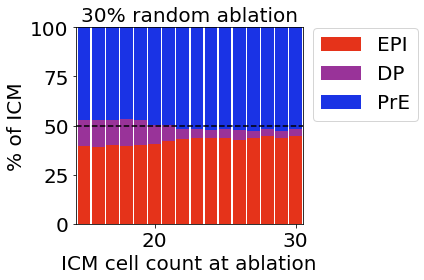

In [28]:
N2abvec = np.arange(15,31,1)
Nvec = np.zeros(len(N2abvec))
dpvec = np.zeros(len(N2abvec))
epivec = np.zeros(len(N2abvec))
prevec = np.zeros(len(N2abvec))
sddpvec = np.zeros(len(N2abvec))
sdepivec = np.zeros(len(N2abvec))
sdprevec = np.zeros(len(N2abvec))
fate2ablate = 3
nruns = 100
p2ablate = 0.33
for i,N2ablate in enumerate(N2abvec):
    rngseed = 11*N2ablate
    fracs = run_scan(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate)
    print('N2ablate =', N2ablate, end='\r', flush=True)
    Nvec[i] = fracs[0]
    dpvec[i] = fracs[1]
    epivec[i] = fracs[2]
    prevec[i] = fracs[3]
    sddpvec[i] = fracs[4]
    sdepivec[i] = fracs[5]
    sdprevec[i] = fracs[6]

width = 0.9
p1 = plt.bar(N2abvec, epivec, width, color='#e5331a') #, yerr=sdepivec)
p2 = plt.bar(N2abvec, 100-epivec-prevec, width, bottom=epivec, color='#993399') #, yerr=sddpvec)
p3 = plt.bar(N2abvec, prevec, width, bottom=100-prevec, color='#1a33e5') #, yerr=sdprevec)
plt.xlabel('ICM cell count at ablation')
plt.ylabel('% of ICM')
plt.xlim([np.min(N2abvec)-1/2*1.2,np.max(N2abvec)+1/2])
plt.ylim([0,100])
plt.axhline(50,color='k',ls='--')
plt.title('30% random ablation')
plt.legend((p1[0], p2[0], p3[0]), ('EPI', 'DP', 'PrE'),bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig('figures/fig4_30pct_random_scan.pdf')
plt.show()

Next we scan the **PrE ablation** case, for two fractions of cells being ablated: 30% and 100%.

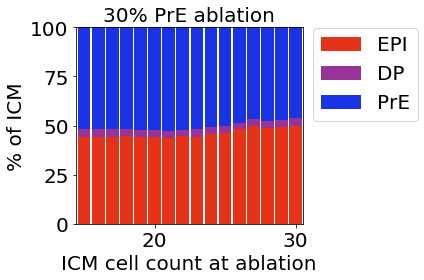

In [29]:
N2abvec = np.arange(15,31,1)
Nvec = np.zeros(len(N2abvec))
dpvec = np.zeros(len(N2abvec))
epivec = np.zeros(len(N2abvec))
prevec = np.zeros(len(N2abvec))
sddpvec = np.zeros(len(N2abvec))
sdepivec = np.zeros(len(N2abvec))
sdprevec = np.zeros(len(N2abvec))
fate2ablate = 2
nruns = 100
p2ablate = 0.3
for i,N2ablate in enumerate(N2abvec):
    rngseed = 11*N2ablate
    fracs = run_scan(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate)
    print('N2ablate =', N2ablate, end='\r', flush=True)
    Nvec[i] = fracs[0]
    dpvec[i] = fracs[1]
    epivec[i] = fracs[2]
    prevec[i] = fracs[3]
    sddpvec[i] = fracs[4]
    sdepivec[i] = fracs[5]
    sdprevec[i] = fracs[6]

width = 0.9
p1 = plt.bar(N2abvec, epivec, width, color='#e5331a') #, yerr=sdepivec)
p2 = plt.bar(N2abvec, 100-epivec-prevec, width, bottom=epivec, color='#993399') #, yerr=sddpvec)
p3 = plt.bar(N2abvec, prevec, width, bottom=100-prevec, color='#1a33e5') #, yerr=sdprevec)
plt.xlabel('ICM cell count at ablation')
plt.ylabel('% of ICM')
plt.xlim([np.min(N2abvec)-1/2*1.2,np.max(N2abvec)+1/2])
plt.ylim([0,100])
plt.title('30% PrE ablation')
plt.legend((p1[0], p2[0], p3[0]), ('EPI', 'DP', 'PrE'),bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig('figures/fig4_30pct_PrE_scan.pdf')
plt.show()

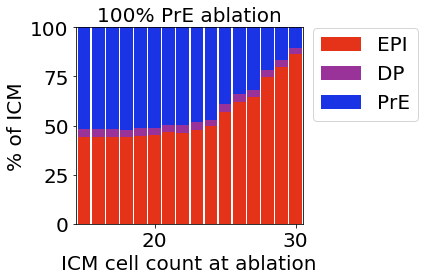

In [30]:
N2abvec = np.arange(15,31,1)
Nvec = np.zeros(len(N2abvec))
dpvec = np.zeros(len(N2abvec))
epivec = np.zeros(len(N2abvec))
prevec = np.zeros(len(N2abvec))
sddpvec = np.zeros(len(N2abvec))
sdepivec = np.zeros(len(N2abvec))
sdprevec = np.zeros(len(N2abvec))
fate2ablate = 2
nruns = 100
p2ablate = 1.0
for i,N2ablate in enumerate(N2abvec):
    rngseed = 11*N2ablate
    fracs = run_scan(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate)
    print('N2ablate =', N2ablate, end='\r', flush=True)
    Nvec[i] = fracs[0]
    dpvec[i] = fracs[1]
    epivec[i] = fracs[2]
    prevec[i] = fracs[3]
    sddpvec[i] = fracs[4]
    sdepivec[i] = fracs[5]
    sdprevec[i] = fracs[6]

width = 0.9
p1 = plt.bar(N2abvec, epivec, width, color='#e5331a') #, yerr=sdepivec)
p2 = plt.bar(N2abvec, 100-epivec-prevec, width, bottom=epivec, color='#993399') #, yerr=sddpvec)
p3 = plt.bar(N2abvec, prevec, width, bottom=100-prevec, color='#1a33e5') #, yerr=sdprevec)
plt.xlabel('ICM cell count at ablation')
plt.ylabel('% of ICM')
plt.xlim([np.min(N2abvec)-1/2*1.2,np.max(N2abvec)+1/2])
plt.ylim([0,100])
plt.title('100% PrE ablation')
plt.legend((p1[0], p2[0], p3[0]), ('EPI', 'DP', 'PrE'),bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig('figures/fig4_100pct_PrE_scan.pdf')
plt.show()

Finally we scan the **EPI ablation** case, again for two fractions of cells being ablated: 30% and 100%.

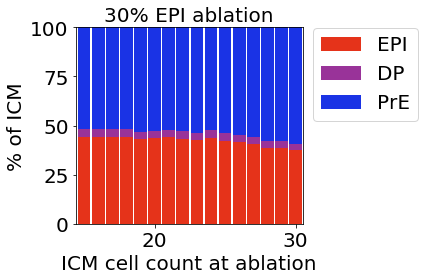

In [31]:
N2abvec = np.arange(15,31,1)
Nvec = np.zeros(len(N2abvec))
dpvec = np.zeros(len(N2abvec))
epivec = np.zeros(len(N2abvec))
prevec = np.zeros(len(N2abvec))
sddpvec = np.zeros(len(N2abvec))
sdepivec = np.zeros(len(N2abvec))
sdprevec = np.zeros(len(N2abvec))
fate2ablate = 1
nruns = 100
p2ablate = 0.30
for i,N2ablate in enumerate(N2abvec):
    rngseed = 11*N2ablate
    fracs = run_scan(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate)
    print('N2ablate =', N2ablate, end='\r', flush=True)
    Nvec[i] = fracs[0]
    dpvec[i] = fracs[1]
    epivec[i] = fracs[2]
    prevec[i] = fracs[3]
    sddpvec[i] = fracs[4]
    sdepivec[i] = fracs[5]
    sdprevec[i] = fracs[6]

width = 0.9
p1 = plt.bar(N2abvec, epivec, width, color='#e5331a') #, yerr=sdepivec)
p2 = plt.bar(N2abvec, 100-epivec-prevec, width, bottom=epivec, color='#993399') #, yerr=sddpvec)
p3 = plt.bar(N2abvec, prevec, width, bottom=100-prevec, color='#1a33e5') #, yerr=sdprevec)
plt.xlabel('ICM cell count at ablation')
plt.ylabel('% of ICM')
plt.ylim([0,100])
plt.xlim([np.min(N2abvec)-1/2*1.2,np.max(N2abvec)+1/2])
plt.title('30% EPI ablation')
plt.legend((p1[0], p2[0], p3[0]), ('EPI', 'DP', 'PrE'),bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig('figures/fig4_30pct_EPI_scan.pdf')
plt.show()

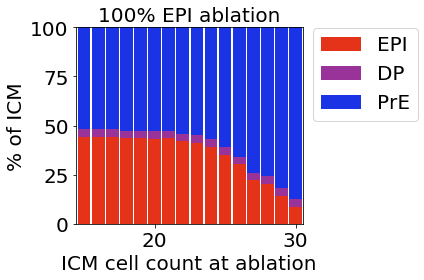

In [32]:
N2abvec = np.arange(15,31,1)
Nvec = np.zeros(len(N2abvec))
dpvec = np.zeros(len(N2abvec))
epivec = np.zeros(len(N2abvec))
prevec = np.zeros(len(N2abvec))
sddpvec = np.zeros(len(N2abvec))
sdepivec = np.zeros(len(N2abvec))
sdprevec = np.zeros(len(N2abvec))
fate2ablate = 1
nruns = 100
p2ablate = 1.0
for i,N2ablate in enumerate(N2abvec):
    rngseed = 11*N2ablate
    fracs = run_scan(nruns=nruns, N2ablate=N2ablate, fate2ablate=fate2ablate, p2ablate=p2ablate)
    print('N2ablate =', N2ablate, end='\r', flush=True)
    Nvec[i] = fracs[0]
    dpvec[i] = fracs[1]
    epivec[i] = fracs[2]
    prevec[i] = fracs[3]
    sddpvec[i] = fracs[4]
    sdepivec[i] = fracs[5]
    sdprevec[i] = fracs[6]

width = 0.9
p1 = plt.bar(N2abvec, epivec, width, color='#e5331a') #, yerr=sdepivec)
p2 = plt.bar(N2abvec, 100-epivec-prevec, width, bottom=epivec, color='#993399') #, yerr=sddpvec)
p3 = plt.bar(N2abvec, prevec, width, bottom=100-prevec, color='#1a33e5') #, yerr=sdprevec)
plt.xlabel('ICM cell count at ablation')
plt.ylabel('% of ICM')
plt.ylim([0,100])
plt.xlim([np.min(N2abvec)-1/2*1.2,np.max(N2abvec)+1/2])
plt.title('100% EPI ablation')
plt.legend((p1[0], p2[0], p3[0]), ('EPI', 'DP', 'PrE'),bbox_to_anchor=(1.0, 1.05))
plt.tight_layout()
plt.savefig('figures/fig4_100pct_EPI_scan.pdf')
plt.show()